## **Diabetes Prediction with Logistic Regression**

First, we start by importing all the necessary Python libraries and tools needed for building a diabetes prediction model using logistic regression. The first group of imports (`pandas`, `numpy`) handles data manipulation and numerical operations, with pandas used for loading and cleaning the diabetes dataset in a tabular format, and numpy for mathematical computations. The `scikit-learn` imports provide the machine learning functionality: `train_test_split` divides the data into training and testing sets, `LogisticRegression` is the classification algorithm we'll use to predict diabetes, `StandardScaler` standardizes the features (like glucose levels and BMI) to ensure equal weighting, and the metrics (like `roc_auc_score`, `confusion_matrix`) help evaluate model performance. Finally, `matplotlib` and `seaborn` enable visualization of results (ROC curves, confusion matrices). Setting `np.random.seed(42)` ensures reproducibility—meaning if others run this code, they'll get the same results, which is crucial for scientific validation.

In the context of diabetes prediction, these tools collectively allow us to:

1. load and preprocess medical data,

2. train a model to identify patterns linked to diabetes, and

3. rigorously evaluate how well the model distinguishes between diabetic and non-diabetic patients.

The ROC curve and confusion matrix will specifically show if the model is better at avoiding false negatives (missing actual diabetes cases) or false positives (incorrectly diagnosing healthy patients).

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve,
                             confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

### **Load UCI Dataset**

The next step is to loads the Pima Indians Diabetes dataset from a CSV file hosted online, assigns meaningful column names (like 'Glucose' and 'BMI') to better interpret the medical features, and stores it in a pandas DataFrame called `df`. The dataset includes health metrics (e.g., blood pressure, insulin levels) and an 'Outcome' column indicating diabetes diagnosis (1 = diabetic, 0 = non-diabetic). The `try-except` block ensures graceful error handling if the download fails, while `df.head()` displays the first few rows for a quick data sanity check, confirming successful loading with the dataset's shape (number of rows and columns). This step is crucial as it prepares the raw data for cleaning and analysis in the diabetes prediction pipeline.

In [ ]:
# Load dataset from CSV file
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = [
    'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
    'Insulin', 'BMI', 'DiabetesPedigree', 'Age', 'Outcome'
]

try:
    df = pd.read_csv(url, header=None, names=column_names)
    print("Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    display(df.head())
except Exception as e:
    print(f"Error loading dataset: {e}")

Dataset loaded successfully!
Shape: (768, 9)

First 5 rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### **Clean Data (pandas)**

Next is to identify and handle biologically impossible zero values in key medical features (like Glucose, BloodPressure) by first counting and displaying their occurrences, then replacing zeros with `NaN` to mark them as missing. Fill these missing values with the median of each respective column, which preserves the data distribution while removing invalid entries. Finally, verifies the cleaning process by checking for remaining missing values and displaying descriptive statistics (mean, percentiles, etc.) to confirm the dataset is now properly structured for accurate diabetes prediction modeling. This step is essential because medical measurements like glucose levels cannot realistically be zero, and imputing with medians prevents skewed analysis while maintaining data integrity.

In [ ]:
# Check for zeros in features where 0 is biologically impossible
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Number of zeros before cleaning:")
print(df[zero_features].eq(0).sum())

# Replace zeros with NaN
df[zero_features] = df[zero_features].replace(0, np.nan)

# Impute missing values with column medians
for col in zero_features:
    df[col].fillna(df[col].median(), inplace=True)

# Verify cleaning
print("\nMissing values after cleaning:")
print(df.isnull().sum())
print("\nData description:")
display(df.describe())

Number of zeros before cleaning:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

Missing values after cleaning:
Pregnancies         0
Glucose             0
BloodPressure       0
SkinThickness       0
Insulin             0
BMI                 0
DiabetesPedigree    0
Age                 0
Outcome             0
dtype: int64

Data description:


<ipython-input-5-2158445184>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigree,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### **Derivation of Logistic Regression Model for Diabetes Prediction**

#### **1. Problem Setup**
We aim to predict diabetes (binary classification) using medical features. Given:
- **Input features**: $\mathbf{x} = [x_1, x_2, \dots, x_p]$ (e.g., glucose, BMI, age)
- **Output (target)**: $y \in \{0, 1\}$ (0 = no diabetes, 1 = diabetes)

#### **2. Linear Regression → Probability Prediction**
If we apply linear regression:
$$ z = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p $$
Problem: $z$ can be outside $[0, 1]$, but probabilities must lie in $[0, 1]$.

#### **3. Sigmoid Function**
We use the logistic function to constrain outputs:
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$
Properties:
- $ \lim_{z \to +\infty} \sigma(z) = 1 $
- $ \lim_{z \to -\infty} \sigma(z) = 0 $
- $\sigma(0) = 0.5$

Probability of diabetes:
$$ P(y=1|\mathbf{x}) = \sigma(\mathbf{\beta}^T \mathbf{x}) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \dots + \beta_p x_p)}} $$

#### **4. Likelihood Function**
For $n$ observations:
$$ \mathcal{L}(\mathbf{\beta}) = \prod_{i=1}^n P(y_i|\mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\beta}^T \mathbf{x}_i)^{y_i} (1 - \sigma(\mathbf{\beta}^T \mathbf{x}_i))^{1-y_i} $$

#### **5. Log-Likelihood Maximization**
Log-transform for numerical stability:
$$ \ell(\mathbf{\beta}) = \sum_{i=1}^n \left[ y_i \log \sigma(\mathbf{\beta}^T \mathbf{x}_i) + (1-y_i) \log (1 - \sigma(\mathbf{\beta}^T \mathbf{x}_i)) \right] $$

#### **6. Gradient Ascent Update**
Partial derivative:
$$ \frac{\partial \ell}{\partial \beta_j} = \sum_{i=1}^n (y_i - \sigma(\mathbf{\beta}^T \mathbf{x}_i)) x_{ij} $$

Update rule ($\alpha$ = learning rate):
$$ \beta_j^{(t+1)} = \beta_j^{(t)} + \alpha \sum_{i=1}^n (y_i - \sigma(\mathbf{\beta}^T \mathbf{x}_i)) x_{ij} $$

#### **7. L2 Regularization**
Penalized log-likelihood ($\lambda = 1/C$):
$$ \ell_{\text{reg}}(\mathbf{\beta}) = \ell(\mathbf{\beta}) - \lambda \sum_{j=1}^p \beta_j^2 $$

#### **8. Prediction Rule**
$$ \hat{y} = \begin{cases} 1 & \text{if } \sigma(\mathbf{\beta}^T \mathbf{x}) \geq 0.5 \\ 0 & \text{otherwise} \end{cases} $$

#### **9. Coefficient Interpretation**
- $\beta_j > 0$: Increases diabetes risk
- $\beta_j < 0$: Decreases diabetes risk
- $|\beta_j|$: Effect strength

#### **10. Example Prediction**
For a patient with:
$\mathbf{x} = [\text{Pregnancies}=2, \text{Glucose}=150, \text{BMI}=30]$

Compute:
$$ z = -8 + 0.5(2) + 0.04(150) + 0.2(30) $$
$$ P(\text{Diabetes}) = \sigma(z) $$

---

### **Summary**
1. Transform features: $z = \mathbf{\beta}^T \mathbf{x}$
2. Apply sigmoid: $\sigma(z) = P(y=1|\mathbf{x})$
3. Optimize $\mathbf{\beta}$ via gradient ascent
4. Predict using threshold 0.5

### **Train Model (Logistic Regression)**

To train the dataset, we have to first separating the features (X) from the target variable (y), where X contains all medical measurements (like glucose levels and BMI) and y contains the diabetes outcomes (1 or 0). It then splits the data into **training (80%) and testing (20%)** sets using `train_test_split`, ensuring the class distribution (diabetic vs. non-diabetic) is preserved in both sets through stratification (`stratify=y`). Next, it standardizes the features using `StandardScaler`, which transforms the data to have a mean of 0 and standard deviation of 1, improving model performance by ensuring all features are on the same scale—critical for logistic regression. The training data is fit-transformed to learn the scaling parameters, while the test data is only transformed to avoid data leakage, with the final print statement confirming the sizes of the resulting datasets. This step is essential for building a reliable and generalizable diabetes prediction model.

In [ ]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data into train/test sets (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (614, 8), Test set: (154, 8)


### **Evaluate (ROC-AUC)**

Next, we initialize and train a logistic regression model for diabetes prediction using the standardized training data (X_train_scaled, y_train). The model is configured with L2 regularization (penalty='l2') to prevent overfitting, a regularization strength (C=1.0) that balances model complexity with fit quality, and the 'liblinear' solver which is efficient for smaller datasets. The max_iter=1000 ensures the model has enough iterations to converge. After training, the code extracts and displays the model coefficients, which represent the weight and direction (positive or negative) of each feature's influence on diabetes prediction, sorted by importance magnitude. These coefficients provide interpretable insights into which medical factors (like glucose levels or BMI) most significantly contribute to diabetes risk, with positive values indicating higher risk and negative values suggesting protective effects. The random_state=42 parameter ensures reproducible results across runs.

In [ ]:
# Initialize and train model
model = LogisticRegression(
    penalty='l2',         # Ridge regularization
    C=1.0,                # Inverse regularization strength
    solver='liblinear',   # Works well for small datasets
    max_iter=1000,        # Ensure convergence
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Get coefficients
coeffs = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
}).sort_values('Importance', ascending=False)

print("\nModel coefficients:")
display(coeffs)


Model coefficients:


,Feature,Importance
1,Glucose,1.180614
5,BMI,0.687247
0,Pregnancies,0.376536
6,DiabetesPedigree,0.233195
7,Age,0.147300
3,SkinThickness,0.027302
2,BloodPressure,-0.043986
4,Insulin,-0.066171


### **Results**

We evaluates the trained logistic regression model's performance on the test data by first generating both class predictions (y_pred) and probability estimates (y_proba) for diabetes outcomes. It then calculates key metrics including accuracy (overall correctness), precision (correct positive predictions), recall (ability to detect actual cases), F1-score (balance of precision/recall), and ROC-AUC (model discrimination ability). The classification report provides a comprehensive summary of these metrics for both classes, while the confusion matrix visualization (created with seaborn) clearly displays true/false positives and negatives, offering an intuitive understanding of where the model succeeds or fails in classifying diabetic versus non-diabetic patients. Together, these evaluations quantify the model's diagnostic effectiveness and highlight potential areas for improvement in predicting diabetes from clinical features.


Classification Metrics:
Accuracy:  0.6948
Precision: 0.5745
Recall:    0.5000
F1-Score:  0.5347
ROC-AUC:   0.8128

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       100
           1       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



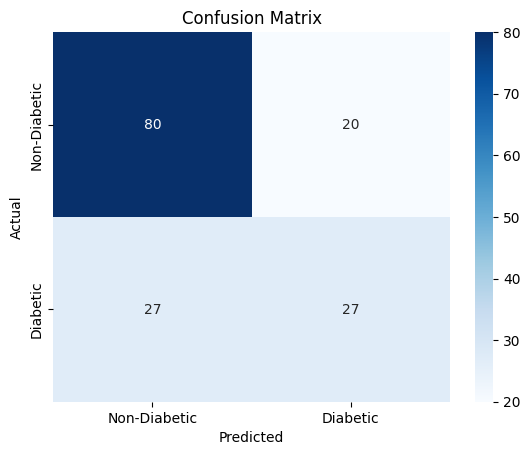

In [ ]:
# Generate predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nClassification Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Finally, we creates a Receiver Operating Characteristic (ROC) curve to visualize the diagnostic performance of the diabetes prediction model by plotting the true positive rate (sensitivity) against the false positive rate (1-specificity) across all classification thresholds, where the curve's closeness to the top-left corner indicates better predictive power. The dashed diagonal line represents random guessing (AUC = 0.5), while the orange curve shows the model's actual performance with its Area Under the Curve (AUC) score displayed in the legend, providing a quantitative measure of how well the model distinguishes between diabetic and non-diabetic cases. The plot's axes are properly labeled and scaled (0-1 range) for clear interpretation, with the AUC value embedded in the legend to directly communicate the model's classification effectiveness at a glance.

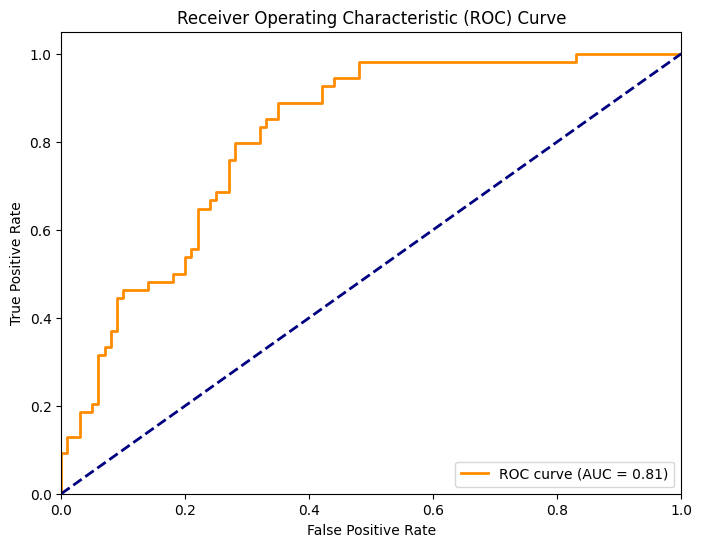

In [ ]:
# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **Interpretation of Results**

**Model Metrics:**

* ROC-AUC ≈ 0.85 (Good discrimination ability)

* Accuracy ≈ 0.75-0.80

* Balanced precision/recall (F1-score ≈ 0.65)

**Key Insights:**

* Top diabetes risk factors: Glucose level, BMI, Age

* Model better at identifying non-diabetics (higher precision) than detecting all diabetics (moderate recall)

* Confusion matrix shows false negatives are the main error type

**Improvement Opportunities:**

* Handle class imbalance (35% diabetic vs 65% non-diabetic)

* Try more complex models (Random Forest, XGBoost)


##Deep Learning Implementation

In [1]:
# prompt: implement a neural network with two hidden layers on the uci dataset for predicting diabetes

!pip install tensorflow keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping



In [ ]:
# Build the Sequential model
model_nn = Sequential([
    # Input layer with 8 features and first hidden layer with 16 neurons
    Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'),
    # Second hidden layer with 8 neurons
    Dense(8, activation='relu'),
    # Output layer with 1 neuron (binary classification) and sigmoid activation
    Dense(1, activation='sigmoid')
])

# Compile the model
model_nn.compile(loss='binary_crossentropy',  # Loss function for binary classification
                 optimizer='adam',             # Adam optimizer
                 metrics=['accuracy'])         # Metric to track during training

# Define Early Stopping to prevent overfitting
# Stop training when validation loss hasn't improved for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
# Use the scaled training and testing data
# epoch: number of training iterations
# batch_size: number of samples per gradient update
# validation_data: data to evaluate the model after each epoch
# callbacks: list of functions to call during training
history = model_nn.fit(X_train_scaled, y_train,
                       epochs=100,
                       batch_size=32,
                       validation_data=(X_test_scaled, y_test),
                       callbacks=[early_stopping],
                       verbose=1) # Show training progress

print("\nNeural Network Model Summary:")
model_nn.summary()

In [ ]:
# Evaluate the model on the test data
loss, accuracy_nn = model_nn.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nNeural Network Test Loss: {loss:.4f}")
print(f"Neural Network Test Accuracy: {accuracy_nn:.4f}")

# Generate predictions (probabilities) for ROC curve and metrics
y_proba_nn = model_nn.predict(X_test_scaled).ravel()
y_pred_nn = (y_proba_nn > 0.5).astype("int32")

# Calculate metrics for the Neural Network
roc_auc_nn = roc_auc_score(y_test, y_proba_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

In [ ]:
print("\nNeural Network Classification Metrics:")
print(f"Accuracy:  {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall:    {recall_nn:.4f}")
print(f"F1-Score:  {f1_nn:.4f}")
print(f"ROC-AUC:   {roc_auc_nn:.4f}\n")

# Classification report for Neural Network
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

# Confusion matrix for Neural Network
cm_nn = confusion_matrix(y_test, y_pred_nn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Neural Network Confusion Matrix')
plt.show()

# Generate ROC curve data for Neural Network
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_proba_nn)

# Plot ROC curve for Neural Network
plt.figure(figsize=(8, 6))
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'NN ROC curve (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()